![title banner](../banners/start_banner.png)

# Using Neural Network to predict stock returns

Neural Networks can be used to automate a multitude of tasks such as image classification and speech recognition. But can they be used to judge the price of stocks? 

In this notebook we will layout a simple model which can be used to predict future stock returns. We will build our NN such that it inputs the past 10 days of stock returns and uses that data to calculate the return for the next day.

The aim of this notebook is to demonstrate data storytelling in a simple way:
1. We obtain data, in this case about Gamestop (GME)
2. In this case, our "research" question is : **Can we accurately forecast future returns using past returns?**
3. We apply a Neural Network as our modelling technique, partitioning our dataset into train/test, fitting the model, then evaluating it.
4. Further evaluation of our technique

### **Importing libaries**

Let's import a few libraries to get us going. You can find the names and documentation of the libraries below:
 

1.   [Pandas](https://pandas.pydata.org/docs/index.html)
2.   [Numpy](https://numpy.org/doc/)
3.   [yfinance](https://algotrading101.com/learn/yfinance-guide/)


In [1]:
"""
key imports, in the Colab environment
we also need to install some packages e.g. yfinance
"""
!pip3 install -qq yfinance

import numpy as np
import pandas as pd
import yfinance as yf

     |████████████████████████████████| 5.5MB 11.3MB/s 


### **Importing stock data**

Python has a lot of useful libraries, some of which can help us collect data. One of them is the `yfinance` library.

Using the `yfinance` library we will import data on GME which we can feed into our neural network.



In [2]:
prices = yf.Ticker("GME")

#Import our data (period="max" means that we gather all the data available i.e. from the first trading day)
temp = prices.history(period="max")

temp = temp.reset_index() #adding an index to our dataset

display(temp)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2002-02-13,6.480513,6.773399,6.413183,6.766666,19054000,0.0,0.0
1,2002-02-14,6.850831,6.864296,6.682506,6.733003,2755400,0.0,0.0
2,2002-02-15,6.733001,6.749833,6.632006,6.699336,2097400,0.0,0.0
3,2002-02-19,6.665671,6.665671,6.312189,6.430017,1852600,0.0,0.0
4,2002-02-20,6.463681,6.648838,6.413183,6.648838,1723200,0.0,0.0
...,...,...,...,...,...,...,...,...
4787,2021-02-19,41.279999,43.889999,38.500000,40.590000,14678700,0.0,0.0
4788,2021-02-22,46.689999,48.509998,42.400002,46.000000,19338400,0.0,0.0
4789,2021-02-23,44.970001,46.230000,40.000000,44.970001,7516000,0.0,0.0
4790,2021-02-24,44.700001,91.709999,44.700001,91.709999,76315700,0.0,0.0


### **Data Preprocessing and Visualisation**
Now that we have our data, let's plot a simple to get a good idea of the stock prices. Plotting gives us a feel of the data, and lets us catch any modelling assumptions or feature engineering we might need to make

`.loc` Allows you to access a row or a set of rows. In this case, we are accessing all rows which have a date equaal to or bigger than 1st Jan 2021.

`pandas`'s in built plot function allows us to quickly build plots. Some other plotting libraries are:

+ `matplotlib`
+ `seaborn`
+ `plotly`



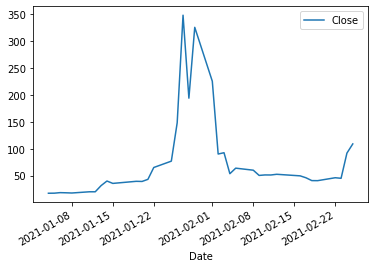

In [3]:
temp.loc[temp['Date'] >= "2021-01-01",['Date','Close']].plot(x = 'Date', y ='Close')

Now that we know what our data looks like, let's preprocess it to make it suitable to feed into our NN. First we will create a **returns** column which will tell us the everyday returns of the GME stock.

Here's where we might use *domain knowledge*. A common "stylised fact" of financial econometrics, is that prices tend to be non-stationary, where as log-returns i.e. the percentage changes tend to be more stationary. What stationary means in this contet, is that the distribution remains the same over time: prices might range, for example from 3 - 300, but the daily log-returns (percentage) change will probably be between 0 - 0.2 (0 - 20%)

`np.diff` takes the difference between every 2 values in the column.


In [4]:
temp['returns'] = np.log(temp['Close']).diff(1)
#display(temp)

We said at the beginning that we will feed in the returns of the previous 10 days into our model. A simple way to do this is to group each day's stock return with the returns of the past 10 days. 

Hence, we will create 10 additional columns with the name **returns_lag_i** where i represents the return of the past ith day.

As always, typical modelling - or in this case supervised learning tasks - require features /  explanatory variables $X$, and a dependent variable / target $y$. Here we're assuming that past returns have *some association* and can be used to predict the future return

In [5]:
#Create the 10 columns
LAGS = 10
for i in range(1, LAGS + 1):
  temp['returns_lag_'+ str(i)] = temp['returns'].shift(i)
display(temp)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,returns,returns_lag_1,returns_lag_2,returns_lag_3,returns_lag_4,returns_lag_5,returns_lag_6,returns_lag_7,returns_lag_8,returns_lag_9,returns_lag_10
0,2002-02-13,6.480513,6.773399,6.413183,6.766666,19054000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2002-02-14,6.850831,6.864296,6.682506,6.733003,2755400,0.0,0.0,-0.004987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2002-02-15,6.733001,6.749833,6.632006,6.699336,2097400,0.0,0.0,-0.005013,-0.004987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2002-02-19,6.665671,6.665671,6.312189,6.430017,1852600,0.0,0.0,-0.041031,-0.005013,-0.004987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2002-02-20,6.463681,6.648838,6.413183,6.648838,1723200,0.0,0.0,0.033465,-0.041031,-0.005013,-0.004987,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4787,2021-02-19,41.279999,43.889999,38.500000,40.590000,14678700,0.0,0.0,-0.002461,-0.121354,-0.074838,-0.056732,0.025122,-0.001955,0.017536,-0.176141,-0.060938,0.175601,-0.546554
4788,2021-02-22,46.689999,48.509998,42.400002,46.000000,19338400,0.0,0.0,0.125120,-0.002461,-0.121354,-0.074838,-0.056732,0.025122,-0.001955,0.017536,-0.176141,-0.060938,0.175601
4789,2021-02-23,44.970001,46.230000,40.000000,44.970001,7516000,0.0,0.0,-0.022646,0.125120,-0.002461,-0.121354,-0.074838,-0.056732,0.025122,-0.001955,0.017536,-0.176141,-0.060938
4790,2021-02-24,44.700001,91.709999,44.700001,91.709999,76315700,0.0,0.0,0.712636,-0.022646,0.125120,-0.002461,-0.121354,-0.074838,-0.056732,0.025122,-0.001955,0.017536,-0.176141


Now we need to convert our data into an array so that it can actually be used by neural network.

Notice that for the first 12 rows of our data, some of the values are NaN. To avoid this problem we will simply skip these values and start with the 12th row.

**X** contains the returns of the previous ten days i.e. the data we will input in our neural network. It is also usually referred to as the training data.

**y** contains the return of the current day i.e. the number we want the output of our neural network to be close to. It is also referred to as the training label.

In [6]:
X = temp[['returns_lag_' + str(i) for i in range(1, LAGS + 1)]].iloc[LAGS+2:].values
y = temp['returns'].iloc[LAGS+2:].values

Let's seperate a small portion of our training data **X** inorder to create a testing dataset. We will perform a similar calculation on **y**.

In [7]:
Xtest = X[-500:]
ytest = y[-500:]
X = X[0:len(X)-500]
y = y[0:len(y)-500]

To get a better idea of our data, let's print out their shapes:

In [8]:
print(X.shape)
print(y.shape)

print(Xtest.shape)
print(ytest.shape)

(4280, 10)
(4280,)
(500, 10)
(500,)


## **Modelling our Neural Network**
Now for the fun part! Let's get to building our Neural Network. We've chosen a Neural Network as our model. For an unfamiliar reader, a Neural Network is a model that "learns" a function by minimising an objective. In this case, we want to learn a function that minimises the error, or *squared distance* between the predictions and the true future returns (more on the Tensorflow Tutorial https://www.tensorflow.org/tutorials)

We will be using Tensorflow to build our neural network as it makes most of the coding straightforward simple.

Let's import the necessary libraries from tensorflow:


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

Now we need to define what structure of our neural network. The structure of the model can take any form and it is up to the user to change it to their needs. 

We've used a simple model in which we have an input layer of 10 nodes, a second layer of 20 nodes and an outlayer of 1 node.

However, we encourage you to play around with the structure and test different models to decide which one is the best.

In [10]:
model = Sequential()
model.add(Dense(20, input_shape=(LAGS,), activation='relu'))
model.add(Dense(1))

model.compile(optimizer='Adam', loss='mean_squared_error')
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                220       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 241
Trainable params: 241
Non-trainable params: 0
_________________________________________________________________


### **Training our model**

Let's input our training data to train it:

When modelling we need to take care and really understand what our model is doing. For example, we can't "shuffle" the data - change the order of the rows because our data actually has a sequential order - row 1 is day 1 - 10, row 2 is day 2 - 11  -if we change the order, we may be inadvertedly expose the model to "future data" within training

In [11]:
model.fit(X, y, epochs=10, shuffle=False, batch_size=32)

Epoch 1/10
134/134 [==============================] - 1s 895us/step - loss: 0.0012
Epoch 2/10
134/134 [==============================] - 0s 984us/step - loss: 9.6055e-04
Epoch 3/10
134/134 [==============================] - 0s 924us/step - loss: 9.4207e-04
Epoch 4/10
134/134 [==============================] - 0s 955us/step - loss: 9.3406e-04
Epoch 5/10
134/134 [==============================] - 0s 931us/step - loss: 9.2870e-04
Epoch 6/10
134/134 [==============================] - 0s 1ms/step - loss: 9.2567e-04
Epoch 7/10
134/134 [==============================] - 0s 945us/step - loss: 9.2148e-04
Epoch 8/10
134/134 [==============================] - 0s 1ms/step - loss: 9.1914e-04
Epoch 9/10
134/134 [==============================] - 0s 932us/step - loss: 9.1448e-04
Epoch 10/10
134/134 [==============================] - 0s 967us/step - loss: 9.1151e-04


### **Testing our data**
Now let's see how our data performs on unseen data:

In [12]:
model.evaluate(Xtest, ytest)

16/16 [==============================] - 0s 1ms/step - loss: 0.0172


0.01715780422091484

It's hard to evaluate the `0.0138` loss we got and what it means. So let's plot a graph of the stock returns our model predicted versus the actual stock returns of that day.

We examine two plots: Predictions and True Returns on the same plot, and the plot of Predictions (y - axis) vs True Returns (x-axis)

In [13]:
predict = model.predict(Xtest)

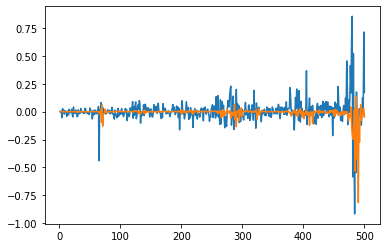

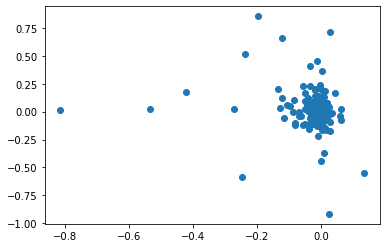

In [14]:
import matplotlib.pyplot as plt
plt.plot(range(1,501), ytest, label = "Actual")
plt.plot(range(1,501), predict, label = "Predicted")
plt.show()

plt.scatter(predict, ytest)

How can we evaluate this? If the model was fairly accurate, the second plot would have the points closer to a 45-degree straight line - whereas the points are in a circular, random shape. Moreover, we can see that our model is not very accurate. For example, it only predicts large increase/decrease after a largeincrease /decrease occurs!


What can we take away from this? Either our model is not fully optimal - there are ways we can improve our model: For example, you can add more layers, increasing the complexity of the neural network but maybe improving its score. Perhaps we have not misspecified the problem - instead of prediction the return, we can predict the direction , i.e. $y > 0$ (classification). Perhaps we could benefit from having more variables to your dataset - You can include data about the companies' dividend policy, income, etc. Or perhaps the limitation is that the task itself is too noisy (see this [link](https://medium.com/analytics-vidhya/no-lstms-cant-predict-stock-prices-11f10dcb35d6)); it is just too difficult to predict returns with any model. All of these and none of these may be valid.

Then what can we do next? We reiterate, and re-evaluate - the typical data science process.





![end banner](../banners/finish_banner.png)